In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import re
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import lognorm

In [40]:
def getPopSizeOverTimeFromFile(filename):
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter="\t")
        nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
        # also this skips the first line, which is all headers
        
        column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
        for row in reader:
            for i in range(len(row)):
                column_array[i].append(float(row[i].strip()))
                
        return column_array
        
        
        
        
times, nAlive, nDead = getPopSizeOverTimeFromFile('Pyrithione_testing_c=10.0.txt') 
print(nAlive)

[599999.667, 591292.833, 582710.333, 574173.167, 565866.833, 557596.167, 549451.5, 541439.167, 533490.833, 525672.333, 518055.5, 510538.167, 503120.833, 495807.667, 488622.167, 481472.5, 474471.833, 467567.0, 460800.167, 454136.167, 447505.0, 441050.5, 434606.333, 428353.833, 422120.0, 415980.833, 409952.5, 403978.333, 398105.333, 392270.333, 386547.833, 380871.167, 375304.833, 369834.667, 364487.0, 359138.5, 353921.5, 348804.5, 343730.0, 338776.833, 333898.167, 329072.167, 324325.333, 319586.833, 314930.333, 310361.5, 305869.833, 301410.667, 297025.5, 292745.5, 288474.333, 284245.167, 280069.167, 275976.333, 271947.667, 267925.667, 263994.833, 260108.333, 256352.333, 252609.5, 248955.833, 245342.5, 241805.0, 238299.667, 234785.333, 231369.5, 227985.5, 224673.167, 221401.5, 218190.833, 215014.0, 211894.167, 208785.5, 205762.5, 202777.167, 199837.5, 196905.167, 194028.667, 191215.833, 188440.0, 185714.833, 183023.5, 180348.667, 177743.833, 175153.667, 172586.167, 170057.0, 167556.0, 165

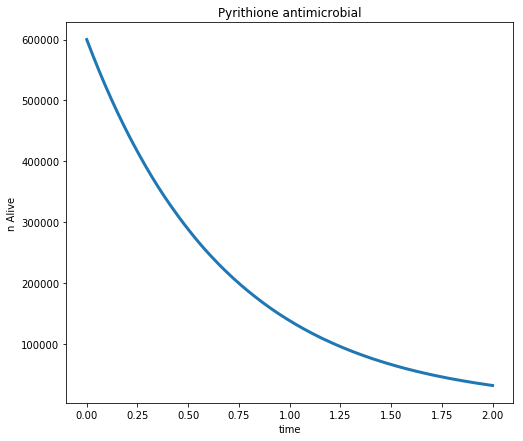

In [41]:
def plotPyrithioneTestingResults(tData, liveData, deadData):
    
    plt.figure(figsize=(8,7))
    plt.plot(tData, liveData, linewidth=3)
    plt.xlabel('time')
    plt.ylabel('n Alive')
    plt.title('Pyrithione antimicrobial')
    plt.savefig('pyrithione_testing_c=10.0.png')
    plt.show()
    
plotPyrithioneTestingResults(times, nAlive, nDead)

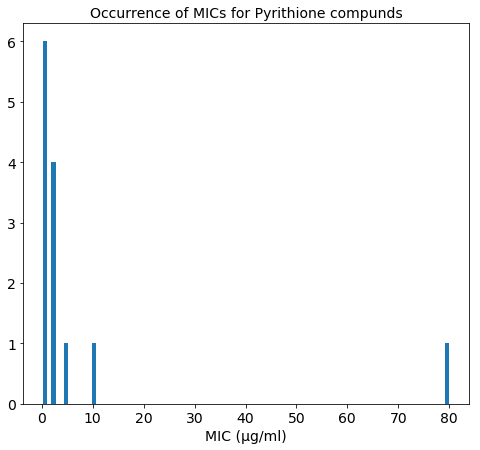

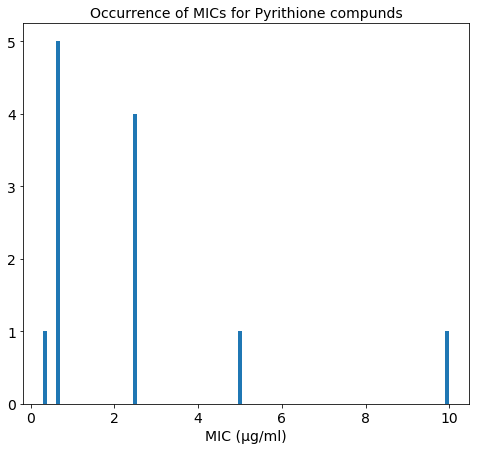

In [42]:
def histogramOfPyrithioneMIC():
    
    #gram-negative bacteria
    listOfMICs = [2.5, 2.5, 5.0, 80.0, 2.5, 10.0]
    #gram-positive bacteria
    listOfMICs2 = [0.6, 0.6, 0.6, 0.6, 0.3, 2.5, 0.6]
    #yeasts
    #listOfMICs3 = [0.15, 1.25, 0.15, 0.3, 0.2]
    
    allMICs = listOfMICs+listOfMICs2
    
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(allMICs, bins=100)
    
    plt.tick_params(labelsize=14)
    plt.title('Occurrence of MICs for Pyrithione compunds', fontsize=font_size)
    plt.xlabel('MIC (μg/ml)', fontsize=font_size)

    plt.savefig('Pyrithione-MIC-histogram.png')
    plt.show()
    

def histogramOfPyrithioneMIC_noOutlier():
    
    #gram-negative bacteria
    listOfMICs = [2.5, 2.5, 5.0, 2.5, 10.0]
    #gram-positive bacteria
    listOfMICs2 = [0.6, 0.6, 0.6, 0.6, 0.3, 2.5, 0.6]
    #yeasts
    #listOfMICs3 = [0.15, 1.25, 0.15, 0.3, 0.2]
    
    allMICs = listOfMICs+listOfMICs2
    
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(allMICs, bins=100)
    
    plt.tick_params(labelsize=14)
    plt.title('Occurrence of MICs for Pyrithione compunds', fontsize=font_size)
    plt.xlabel('MIC (μg/ml)', fontsize=font_size)

    plt.savefig('Pyrithione-MIC-histogram-noOutlier.png')
    plt.show()
    
histogramOfPyrithioneMIC()
histogramOfPyrithioneMIC_noOutlier()

8.163972549748646


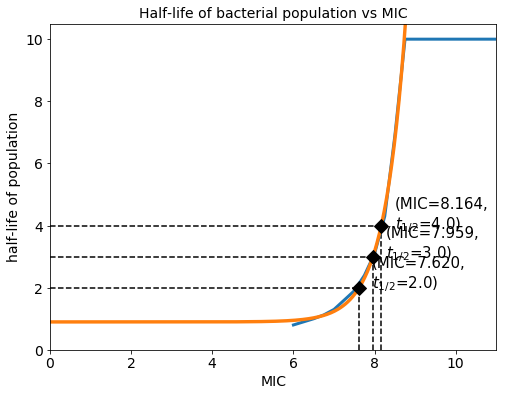

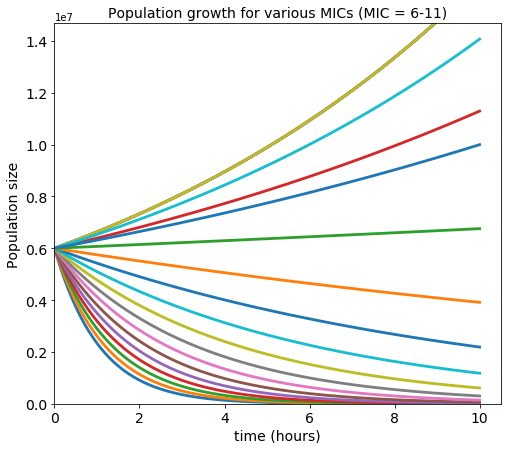

In [237]:
def extractMultipleMICCurves(filename):
    '''returns the list of MICs used, the times sampled over and the corresponding popualtion sizes'''
    
    #filename = 'Pyrithione_MICVarying_c=10.0.txt'
    
    with open(filename) as infile:
        
        reader = csv.reader(infile, delimiter="\t")
        file_headers = next(reader)
        #print(file_headers)
        nCols = len(file_headers) #gets the no. of columns in file, i.e., features of data

        column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
        for row in reader:
            for i in range(len(row)):
                column_array[i].append(float(row[i].strip()))
                
        return file_headers[1:], column_array[0], column_array[1:]
    
    
def getHalfLifeOfMICCurve(timeData, input_curve):
    
    hl_index = -17
    
    for i in range(1, len(input_curve)):
        if input_curve[i] <= 0.5*input_curve[0]:
            hl_index = i
            break
        
    if hl_index > 0:
        return timeData[hl_index]
    else:
        return timeData[0]
    
def getAvgHalfLifeOfMICCurve(timeData, input_curve):
    
    hl_indexes = [0, 0]
    delta_t = [] # this stores all the half lifes measured in the curve
    # initialised with one value to prevent division by zero
    
    for i in range(1, len(input_curve)):
        if input_curve[i] <= 0.5*input_curve[hl_indexes[-1]]:
            hl_indexes.append(i)
            dt = timeData[hl_indexes[-1]] - timeData[hl_indexes[-2]]
            delta_t.append(dt)
            
    #hl_times = [timeData[i] for i in hl_indexes]
    if len(delta_t):
        return sum(delta_t)/len(delta_t)
    else:
        return max(timeData)
    
    

def plotMultipleMICCurves(filename):
    
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename)
    
    plt.figure(figsize=(8,7))
    for mic in MICpops:
        plt.plot(times, mic, linewidth=2.8)
    
    plt.xlim(0,1.05*max(times))
    y_max = max(max(MICpops))
    plt.ylim(0, 1.3*y_max)
    
    font_size=14
    plt.tick_params(labelsize=14)
    plt.title('Population growth for various MICs (MIC = 6-11)', fontsize=font_size)
    plt.xlabel('time (hours)', fontsize=font_size)
    plt.ylabel('Population size', fontsize=font_size)
    plt.savefig('popSize(t)_vs_MIC.png')
    plt.show()
    
    
    
    
def plotHalfLifesOfMICs(filename):
    
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename)
    half_life_lists = [getAvgHalfLifeOfMICCurve(times, mic) for mic in MICpops]
    relevant_hls = half_life_lists[:11] # the non-zero half lifes
    MIC_vals = [float(re.findall("\d+\.\d+", MIC_string)[0]) for MIC_string in MIC_labels]
    
    target_halfLife = 4.# the timeframe in hours desired for the population to decrease by half
    target_halfLife2 = 2.
    target_halfLife3 = 3.
    
    def fit_func(x, a, b, c):
        return b*np.exp(a*x) + c
    
    '''def objective(x, a, b, c):
        #used to find the x-value of the above function given a y value
        return (target_halfLife - fit_func(x, a, b, c))**2
    
    def objective2(x, a, b, c):
        return (target_halfLife2 - fit_func(x, a, b, c))**2
    '''
    #can make a function iside a function to pass values to the optimizer
    def objective_halfLife(targ_hl):
        
        def objective(x, a, b, c):
        #'''used to find the x-value of the above function given a y value'''
            return (targ_hl - fit_func(x, a, b, c))**2
        return objective
    
    #print(MIC_vals)
    mic_arr = np.array(MIC_vals[:11])
    hl_arr = np.array(relevant_hls)
    
    params = curve_fit(fit_func, mic_arr, hl_arr)
    [a, b, c] = params[0]
    
    # here we find the x value (MIC) for a given y-value (half-life)
    def getTargetMIC(targ_hl):
        popt2, pcov2 = curve_fit(fit_func, mic_arr, hl_arr)
        #print(pcov2)
        res = minimize_scalar(objective_halfLife(targ_hl), bracket=(6, 11), args=tuple(popt2))
        return res.x # the half life required to obtain target_halfLife
    
    
    target_MIC = getTargetMIC(target_halfLife)
    target_MIC2 = getTargetMIC(target_halfLife2)
    target_MIC3 = getTargetMIC(target_halfLife3)
    print(target_MIC)
    
    x_vals = np.linspace(0., 12, 400)
    fitted_hls = [fit_func(x, a, b, c) for x in x_vals]
    
    plt.figure(figsize=(8,6))
    plt.plot(MIC_vals, half_life_lists, linewidth=3) #recorded data
    plt.plot(x_vals, fitted_hls, linewidth=3.4) #fitted curve
    
    
    plt.plot(target_MIC, target_halfLife, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC, 0, target_halfLife, linestyle="dashed")
    plt.hlines(target_halfLife, 0, target_MIC, linestyle="dashed")
    targMIC_string = "{:.3f}".format(target_MIC)
    plt.text(target_MIC*1.04, target_halfLife *0.96, "(MIC="+targMIC_string+",\n$t_{1/2}$="+str(target_halfLife)+")", fontsize=15)
    
    plt.plot(target_MIC2, target_halfLife2, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC2, 0, target_halfLife2, linestyle="dashed")
    plt.hlines(target_halfLife2, 0, target_MIC2, linestyle="dashed")
    targMIC_string2 = "{:.3f}".format(target_MIC2)
    plt.text(target_MIC2*1.04, target_halfLife2*0.96, "(MIC="+targMIC_string2+",\n$t_{1/2}$="+str(target_halfLife2)+")", fontsize=15)
    
    plt.plot(target_MIC3, target_halfLife3, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC3, 0, target_halfLife3, linestyle="dashed")
    plt.hlines(target_halfLife3, 0, target_MIC3, linestyle="dashed")
    targMIC_string3 = "{:.3f}".format(target_MIC3)
    plt.text(target_MIC3*1.04, target_halfLife3*0.96, "(MIC="+targMIC_string3+",\n$t_{1/2}$="+str(target_halfLife3)+")", fontsize=15)
    
    font_size=14
    plt.title('Half-life of bacterial population vs MIC', fontsize=font_size)
    plt.xlabel('MIC', fontsize=font_size)
    plt.ylabel('half-life of population', fontsize=font_size)
    
    plt.tick_params(labelsize=14)
    plt.xlim(0,11.)
    plt.ylim(0,1.05*max(times))
    plt.savefig('halfLife_vs_MIC.png')
    plt.show()
    
    
    
    
    
#plotHalfLifesOfMICs('Pyrithione_MICVarying_c=10.0.txt')
#plotMultipleMICCurves('Pyrithione_MICVarying_c=10.0.txt')

plotHalfLifesOfMICs('Pyrithione_MICVarying_c=10.0-extended.txt')
plotMultipleMICCurves('Pyrithione_MICVarying_c=10.0-extended.txt') 


1000000
max: 13.0998
min: 4.8297
avg: 7.960490379000302


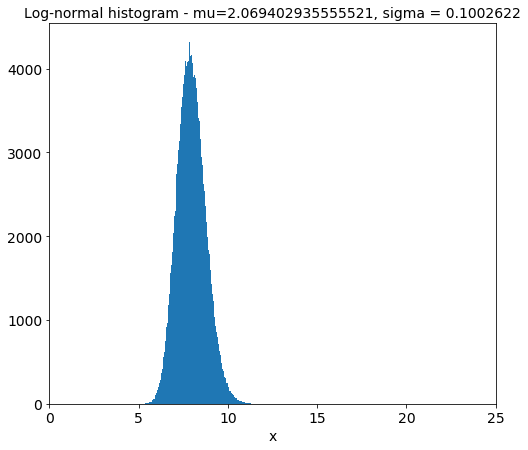

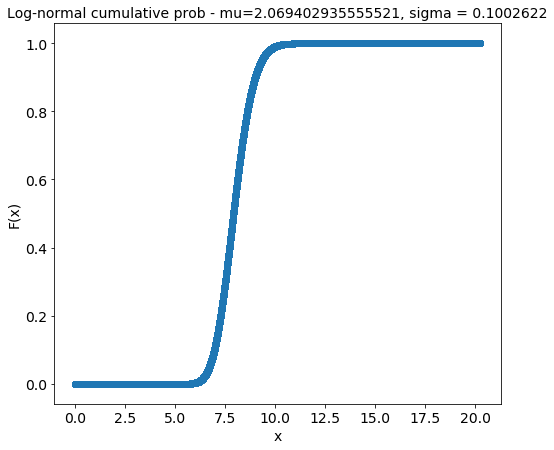

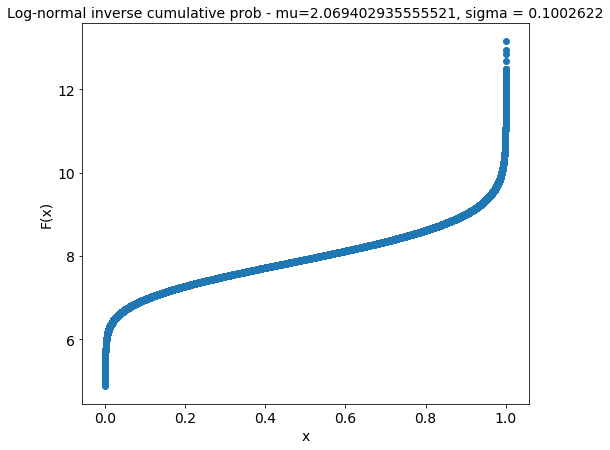

In [15]:
def histogramLogNorms(filename):
    p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
    mu, sigma = [float(i) for i in p.findall(filename)]
    column_array = [] #creates an empty array of length nCols to store the data
    with open(filename) as infile:
        
        reader = csv.reader(infile)
        
        for row in reader:
            column_array.append(float(row[0]))
                
    #column_array = [x for x in column_array if x < 100 ]
    print(len(column_array))
    print("max: "+str(max(column_array)))
    print("min: "+str(min(column_array)))
    #avg = sum(column_array)
    print("avg: "+str(sum(column_array)/len(column_array)))
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(column_array, bins=1000)
    
    plt.tick_params(labelsize=14)
    plt.title('Log-normal histogram - mu='+str(mu)+', sigma = '+str(sigma), fontsize=font_size)
    plt.xlabel('x', fontsize=font_size)
    plt.xlim(0,25)

    plt.savefig('logNorm-histo-mu='+str(mu)+'-sigma='+str(sigma)+'.png')
    plt.show()
    
    
    
def plotCumlProbLogNorm(filename):
    p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
    mu, sigma = [float(i) for i in p.findall(filename)]
    
    def getFileVals(filename):
        with open(filename) as infile:
            
            reader = csv.reader(infile, delimiter="\t")
            nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
            infile.seek(0)
            
            column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
            for row in reader:
                for i in range(len(row)):
                    column_array[i].append(float(row[i].strip()))
                    
            return column_array[0], column_array[1]
        
        
    xVals, yVals = getFileVals(filename)
    
    font_size=14
    plt.figure(figsize=(8,7))
    plt.scatter(xVals, yVals)
    
    plt.tick_params(labelsize=14)
    plt.title('Log-normal cumulative prob - mu='+str(mu)+', sigma = '+str(sigma), fontsize=font_size)
    plt.xlabel('x', fontsize=font_size)
    plt.ylabel('F(x)', fontsize=font_size)


    plt.savefig('logNorm-cumlProb-mu='+str(mu)+'-sigma='+str(sigma)+'.png')
    plt.show()
    
    
def plotInvCumlProb(filename):
    p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
    mu, sigma = [float(i) for i in p.findall(filename)]
    def getFileVals(filename):
        with open(filename) as infile:
            
            reader = csv.reader(infile, delimiter="\t")
            nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
            infile.seek(0)
            
            column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
            for row in reader:
                for i in range(len(row)):
                    column_array[i].append(float(row[i].strip()))
                    
            return column_array[0], column_array[1]
        
        
    xVals, yVals = getFileVals(filename)
    
    font_size=14
    plt.figure(figsize=(8,7))
    plt.scatter(xVals, yVals)
    
    plt.tick_params(labelsize=14)
    plt.title('Log-normal inverse cumulative prob - mu='+str(mu)+', sigma = '+str(sigma), fontsize=font_size)
    plt.xlabel('x', fontsize=font_size)
    plt.ylabel('F(x)', fontsize=font_size)


    plt.savefig('logNorm-invCumlProb-mu='+str(mu)+'-sigma='+str(sigma)+'.png')
    plt.show()
    
    
#histogramLogNorms('lognormal-samples.txt')
histogramLogNorms('LogNormRawData/lognormal-samples_mu=2.069402935555521_sigma=0.1002622.txt')
plotCumlProbLogNorm('LogNormRawData/cumulProbs_mu=2.069402935555521_sigma=0.1002622.txt')
plotInvCumlProb('LogNormRawData/inverseCumulProbs_mu=2.069402935555521_sigma=0.1002622.txt')

In [300]:
def getMuAndSigma(target_mic, percent_resist):
    
    f_inv_val = 1. - percent_resist #the target value of the inverse cuml func: f(target_mean)^-1
    
    
    def inv_cuml_func(targ_mic, mu, sigma):
        return stats.lognorm(s=sigma, scale=math.exp(mu)).ppf(targ_m)
    
    # params = [targ_fInv_y, targ_mic, mu, sigma]
    def objective2(params):
        
        def objective(t_mic, mu, sigma):
            return (params[0] - inv_cuml_func(params[1], params[2], params[3]))**2
        return objective
    
    
    params0 = [f_inv_val, target_mic, 0., 0.]
    
    res = minimize(objective2, params0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
    print(res.x)
    
#getMuAndSigma(7.96, 0.01)  

In [4]:
def getMuAndSigma3(target_mic, N99thPercentileVal):
    
    def inv_cuml_func(resistPercentile, mu, sigma):
        return stats.lognorm(s=sigma, scale=math.exp(mu)).ppf(resistPercentile)
    
    def objective2(params):
        
        mu, sigma = params
    

    
getMuAndSigma3(7.96, 10.)

In [375]:
def getMuAndSigma2(target_mic, percent_resist):
    '''given a desired value for the cdf at a given mic, returns scale and sigma based on the % resitant at that mic
    i.e minimises (%resistant - cdf(given MIC))**2
    
    Here mu is not really mu, but is actually the "scale" parameter of the distribution'''
    f_inv_val = 1. - percent_resist #the target value of the inverse cuml func: f(target_mean)^-1
    
    mu =6.27835764
    scale1 = math.exp(mu)
    sig = 0.102014238 #sigma
    rvs = lognorm.cdf(target_mic,s=sig, scale=mu)
    rvs2 = stats.lognorm(s=sig, scale=mu).cdf(target_mic)
    rvs3 = lognorm(s=sig, scale=mu).mean()
    #j = stats.lognorm.ppf(target_mic, s=sigma, scale=math.exp(mu))
    print(rvs)
    print(rvs3)
    
    # returns the value of the cdf for a given mic
    def func(params):
        mu, sigma = params
        #print(stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(target_mic))
        return (f_inv_val - stats.lognorm(s=sigma, scale=mu).cdf(target_mic))**2
    
    # returns value of ppf for a given desired resistance percentage
    def func2(params):
        mu, sigma = params
        #print(stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(target_mic))
        return (target_mic - stats.lognorm(s=sigma, scale=mu).ppf(f_inv_val))**2
    
    
    
    params0 = [6, 0.1]
    result = minimize(func, params0, method = 'Nelder-Mead')
    print(result.x)
    
    #params0 = [0.1, 6]
    result = minimize(func2, params0, method = 'Nelder-Mead')
    print(result.x)
    
   
    
getMuAndSigma2(7.96, 0.01)  

0.9899999922089653
6.311111918748277
[6.27835764 0.10201423]
[6.27835764 0.10201423]


In [11]:
def getMuAndSigma4(target_mic, percentile_resistVal):
    '''given a desired value for the cdf at a given mic, returns scale and sigma based on the % resitant at that mic
    i.e minimises (%resistant - cdf(given MIC))**2
    
    Here mu is not really mu, but is actually the "scale" parameter of the distribution
    
    percentileresistval is the 99th percentile of the resistance distributions
    
    this returns the scale and sigma needed for the lognormal distributions'''
    #f_inv_val = 1. - percent_resist #the target value of the inverse cuml func: f(target_mean)^-1
    
    mu =7.9200929
    scale1 = math.exp(mu)
    sig = 0.1002622 #sigma
    rvs = lognorm.cdf(target_mic,s=sig, scale=mu)
    rvs2 = stats.lognorm(s=sig, scale=mu).cdf(target_mic)
    rvs3 = lognorm(s=sig, scale=mu).mean()
    #j = stats.lognorm.ppf(target_mic, s=sigma, scale=math.exp(mu))
    print(rvs)
    print(rvs3)
    
    # returns the value of the cdf for a given mic
    def func(params):
        mu, sigma = params
        #print(stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(target_mic))
        #minimises the value of the 99th percentile to 10, and also the mean to 7.96
        minimise99 = (0.99 - stats.lognorm(s=sigma, scale=mu).cdf(percentile_resistVal))**2
        logNormMean = stats.lognorm(s=sigma, scale=mu).mean()
        minimiseMean = (target_mic - logNormMean)**2
        return minimise99 + minimiseMean
    
    # returns value of ppf for a given desired resistance percentage
    def func2(params):
        mu, sigma = params
        #print(stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(target_mic))
        return (target_mic - stats.lognorm(s=sigma, scale=mu).ppf(f_inv_val))**2
    
    
    
    params0 = [6, 0.1]
    result = minimize(func, params0, method = 'Nelder-Mead')
    print(result.x)
    
    #params0 = [0.1, 6]
    #result = minimize(func2, params0, method = 'Nelder-Mead')
    #print(result.x)
    
   
    
getMuAndSigma4(7.96, 10.)  

0.5199902863127368
7.960001512986391
[7.9200929 0.1002622]


In [2]:
def muSigmaRelation():
    
    target_mic = 7.96
    mu_calc = lambda sigma: math.log(target_mic) - 0.5*sigma**2
    
    sigVals = [ x for x in np.arange(0, 0.3, 0.001)]
    muVals = [mu_calc(s) for s in sigVals]
    
    print(len(sigVals))
    print(len(muVals))
    plt.plot(sigVals, muVals)
    plt.xlabel('sigma')
    plt.ylabel('mu')
    plt.show()
    
    for i in range(len(sigVals)):
        for j in range(len(muVals)):
            mu = muVals[i]
            scale = math.exp(mu)
            sigma = sigVals[j]
        
            logNormoCDFVal = lognorm(s=sigma, scale=scale).cdf(target_mic)
            logNormoMeanVal = lognorm(s=sigma, scale=scale).mean()
            #print(logNormoCDFVal)
        
            if logNormoCDFVal >= 0.99 and logNormoCDFVal < 0.9905:            
                print('cdf of '+str(target_mic)+': '+str(logNormoCDFVal))
                print('mean: '+str(logNormoMeanVal))
                print('mu: '+str(mu))
                print('scale: '+str(scale))
                print('sigma: '+str(sigma))
                print()
        
        
        
    
#muSigmaRelation()

In [390]:
def muSigmaRelation2():
    
    target_mic = 7.96
    sigma_calc = lambda mu: math.sqrt(2.*(math.log(target_mic)-mu))
    
    muVals = [ x for x in np.arange(-2., 3, 0.01)]
    sigVals = [x for x in np.arange(0.01, 0.6, 0.001)]
    
    print(len(sigVals))
    print(len(muVals))
    #plt.plot(sigVals, muVals)
    #plt.xlabel('sigma')
    #plt.ylabel('mu')
    #plt.show()
    
    for i in range(len(sigVals)):
        for j in range(len(muVals)):
            mu = muVals[j]
            scale = math.exp(mu)
            sigma = sigVals[i]
        
            logNormoCDFVal = lognorm(s=sigma, scale=scale).cdf(target_mic)
            logNormoMeanVal = lognorm(s=sigma, scale=scale).mean()
            #print(logNormoCDFVal)
        
            if logNormoCDFVal >= 0.99 and logNormoCDFVal < 0.9905 and math.fabs(logNormoMeanVal - target_mic) <= 0.3:            
                print('cdf of '+str(target_mic)+': '+str(logNormoCDFVal))
                print('mean: '+str(logNormoMeanVal))
                print('mu: '+str(mu))
                print('scale: '+str(scale))
                print('sigma: '+str(sigma))
                print()
        
        
        
    
muSigmaRelation2()

590
500


In [ ]:
def muSigmaRelation3():
    
    sigmaVals = [x for x in np.arange(0, 0.3, 0.001)]
    muVals = [x for x in np.arange(1, 3, 0.001)]
    
    